In [9]:
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as T
from tqdm.notebook import tqdm
from torch import nn
import os

import warnings
from models.dataset import BaseDataset
from models.patchgan import PatchGAN
from models.unet import UNet
from models.helper_functions import *
from models.pix2pix_GAN import Pix2PixCGAN

In [17]:
import wandb
wandb.login()

config = dict(
    init_mean = 0.0,
    init_std = 0.02,
    EPOCHS = 200,
    D_architecture = "PatchGAN 70x70",
    G_architecture = "Unet",
    lmbda=100,
    G_lr=2e-4,
    D_lr=2e-4,
)

wandb.init(project="CGAN", name="main", config=config)

### Download data

In [ ]:
!wget http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/facades.tar.gz
!mkdir ./data
!tar -xf ./facades.tar.gz -C ./data/

### Define parameters

In [10]:
# transforms
transform = T.Compose([
    T.Lambda(lambda x: x / 255),
    T.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    T.Resize((286, 286), T.InterpolationMode.BICUBIC, antialias=True)
])

resize_crop = True
inverse_transform = T.Compose([
    T.Normalize(mean=(-1, -1, -1), std=(2, 2, 2)),
    T.Lambda(lambda x: x.clip(0, 1))
])


# parameters
device = "cuda:0" if torch.cuda.is_available() else "cpu"
EPOCHS = 100
batch_size = 1


### Load Data

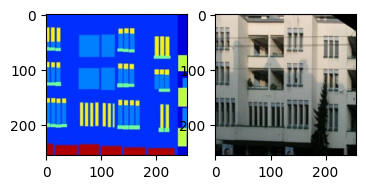

In [11]:
data_dir = './data/facades/train/'
dataset = BaseDataset(data_dir, transform=transform, resize_crop=resize_crop)

dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=False,
    # pin_memory_device=device,
    # pin_memory=True,
    drop_last=True
)
batch = next(iter(dataloader))
X, y = batch

to_img = T.ToPILImage()
img1, img2 = X[0], y[0]
fig, ax = plt.subplots(ncols=2, figsize=(4, 2))
ax[0].imshow(inverse_transform(img1).permute(1, 2, 0))
ax[1].imshow(inverse_transform(img2).permute(1, 2, 0))
plt.show()

### Test and validation data

In [30]:
num_imgs = 5

test_data_dir = './data/facades/test/'
test_dataset = BaseDataset(test_data_dir, transform=transform, resize_crop = resize_crop)
testloader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=num_imgs,
    shuffle=True,
    # pin_memory_device=device,
    # pin_memory=True
)

### Train Function

In [13]:
def train_GAN(model: Pix2PixCGAN, dataloader, checkpoint_path=None):
    if checkpoint_path is None:
        warnings.warn(
            "checkpoint path is set to None, checkpoints will not be saved")

    start = model.epoch
    for epoch in tqdm(range(start, EPOCHS), desc="Epoch"):
        G_running_loss = 0
        D_running_loss = 0

        for i, (X, y) in enumerate(tqdm(dataloader, leave=False, desc=f"Epoch {epoch}")):
            X = X.to(device)
            y = y.to(device)

            # iteration for discriminator
            z_cat, z, D_loss = model.D_step(X, y)

            # iteration for the generator
            G_loss = model.G_step(z_cat, z, y)
            # update running metrics
            D_running_loss += D_loss
            G_running_loss += G_loss

        # logging, saving checkpoints

        # log running loss
        wandb.log({"D_loss": D_running_loss,
                  "G_loss": G_running_loss}, step=epoch)

        # log random images to wandb
        log_imgs(model, testloader, inverse_transform, local=False, step=epoch)

        model.epoch += 1
        
        # save checkpoint
        if epoch and epoch % 20 == 0 and checkpoint_path is not None:
            model.save_checkpoint(checkpoint_path)


### Training

In [ ]:
G_model = UNet()
D_model = PatchGAN() # by default the GAN is 70 x 70
model = Pix2PixCGAN(D_model=D_model, G_model=G_model, device=device).to(device)
init_weights(model, mean=config["init_mean"], std=config["init_std"])


checkpoint_path = os.path.join(os.path.curdir, "checkpoints")

if not os.path.exists(checkpoint_path):
    os.mkdir(checkpoint_path)

# wandb.watch(model)
train_GAN(model, dataloader, checkpoint_path=checkpoint_path)

### Start training from checkpoint 

In [ ]:
G_model = UNet()
D_model = PatchGAN()

model_checkpoint = Pix2PixCGAN(D_model=D_model, G_model=G_model, device=device)
model_checkpoint.load_checkpoint(os.path.join(checkpoint_path, "patchgan_Facades_100.pth"))

model_checkpoint = model_checkpoint.to(device)
wandb.watch(model_checkpoint)

train_GAN(model_checkpoint, dataloader, checkpoint_path)

### Load checkpoints, generate images

In [ ]:
G_model = UNet()
D_model = PatchGAN()

model_checkpoint = Pix2PixCGAN(D_model=D_model, G_model=G_model, device=device)
model_checkpoint.load_checkpoint(os.path.join(checkpoint_path, "patchgan_Facades_100.pth"))

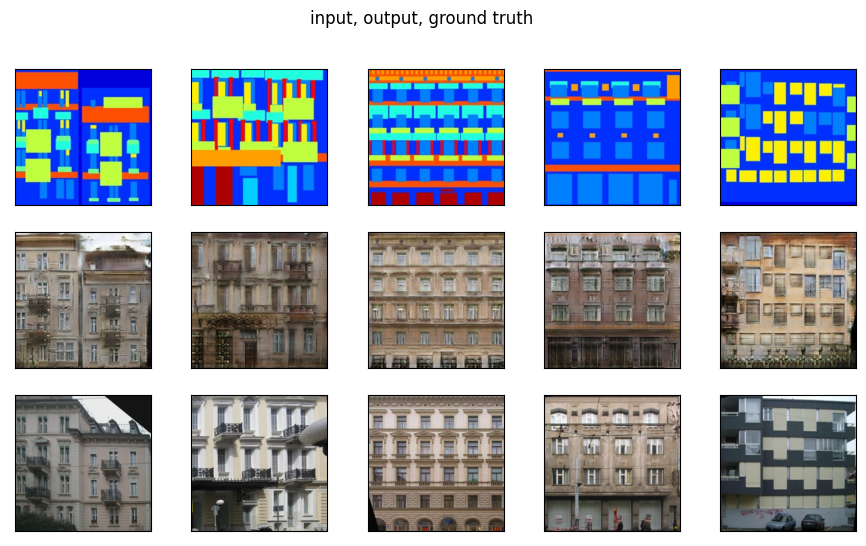

In [33]:
log_imgs(model_checkpoint, testloader, inverse_transform, num_imgs=5)